<a href="https://colab.research.google.com/github/Chaki0981/IMG_classification_rock_paper_scissors/blob/master/Img_class_rock_paper_scissors_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU's not detected")

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2. Load and prepare data

### 2.1 Load data

In [ ]:
ds = tfds.load('rock_paper_scissors', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete3UMYJG/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete3UMYJG/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
data_iterator = ds.as_numpy_iterator()

In [ ]:
data_iterator.next()

{'image': array([[[254, 254, 254],
         [253, 253, 253],
         [254, 254, 254],
         ...,
         [251, 251, 251],
         [250, 250, 250],
         [250, 250, 250]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [253, 253, 253],
         ...,
         [250, 250, 250],
         [251, 251, 251],
         [249, 249, 249]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [251, 251, 251],
         [250, 250, 250],
         [252, 252, 252]],
 
        ...,
 
        [[252, 252, 252],
         [251, 251, 251],
         [252, 252, 252],
         ...,
         [247, 247, 247],
         [249, 249, 249],
         [248, 248, 248]],
 
        [[253, 253, 253],
         [253, 253, 253],
         [251, 251, 251],
         ...,
         [248, 248, 248],
         [248, 248, 248],
         [248, 248, 248]],
 
        [[252, 252, 252],
         [253, 253, 253],
         [252, 252, 252],
         ...,
         [248, 248,

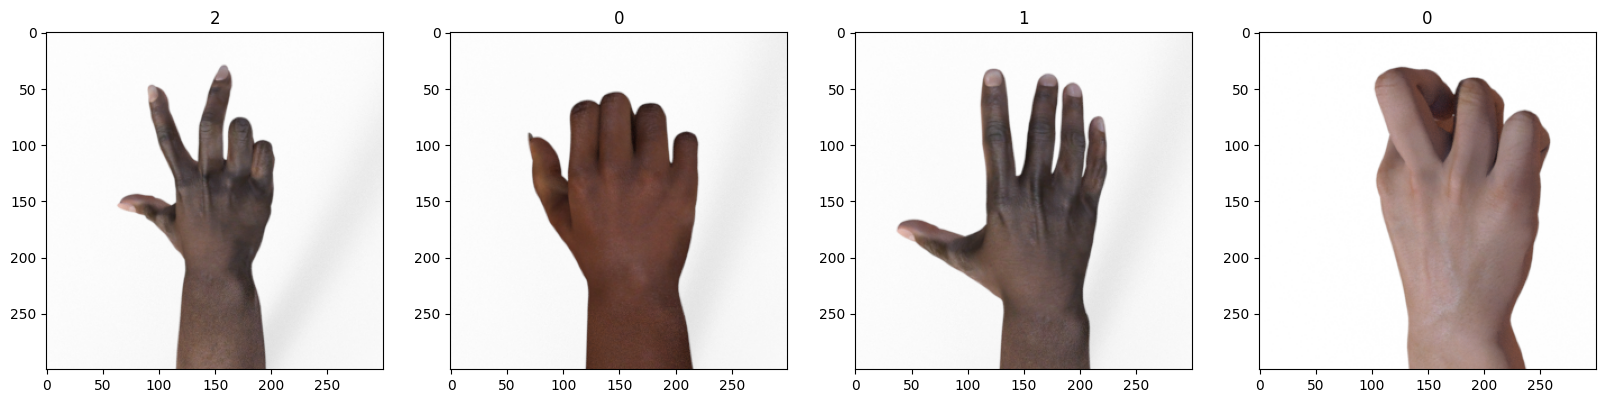

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [ ]:
ds_train = tfds.load('rock_paper_scissors', split='train')

### 2.2 Data processing

In [ ]:
ds_train = ds_train.map(
    lambda batch: (batch['image'], batch['label'])
)

In [ ]:
type(ds_train.as_numpy_iterator().next())

tuple

In [ ]:
ds_train = ds_train.map(
    lambda X, y: (X/255, y)
)

### 2.3 Split data

In [ ]:
len(ds_train)

2520

In [ ]:
train_size = int(len(ds_train)*.75)
val_size = int(len(ds_train)*.25)

In [ ]:
train_size, val_size

(1890, 630)

In [ ]:
train = ds_train.take(train_size)
val = ds_train.skip(train_size).take(val_size)

In [ ]:
type(train)

tensorflow.python.data.ops.take_op._TakeDataset

## 3. Builing Neural Network

### 3.1 Import dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LeakyReLU, Dropout, RandomFlip, RandomRotation

### 3.2 Optimize datasets

In [ ]:
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
    ]
)

In [ ]:
train = train.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [ ]:
train = train.batch(64)
val = val.batch(64)

In [ ]:
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)

### 3.2 Building Deep Learning Model

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, input_shape=(300,300,3)))
model.add(LeakyReLU(0.2))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1))
model.add(LeakyReLU(0.2))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1))
model.add(LeakyReLU(0.2))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))


In [ ]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 298, 298, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                 

### 3.3 Training the model

In [ ]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
30/30 [==============================] - 37s 770ms/step - loss: 1.1485 - accuracy: 0.3968 - val_loss: 1.0055 - val_accuracy: 0.4524
Epoch 2/20
30/30 [==============================] - 15s 515ms/step - loss: 0.7563 - accuracy: 0.7101 - val_loss: 0.6067 - val_accuracy: 0.7048
Epoch 3/20
30/30 [==============================] - 17s 554ms/step - loss: 0.4236 - accuracy: 0.8344 - val_loss: 0.2304 - val_accuracy: 0.9159
Epoch 4/20
30/30 [==============================] - 16s 541ms/step - loss: 0.1833 - accuracy: 0.9466 - val_loss: 0.1779 - val_accuracy: 0.9349
Epoch 5/20
30/30 [==============================] - 17s 553ms/step - loss: 0.1260 - accuracy: 0.9640 - val_loss: 0.0582 - val_accuracy: 0.9889
Epoch 6/20
30/30 [==============================] - 16s 519ms/step - loss: 0.0838 - accuracy: 0.9810 - val_loss: 0.0700 - val_accuracy: 0.9857
Epoch 7/20
30/30 [==============================] - 16s 522ms/step - loss: 0.0790 - accuracy: 0.9788 - val_loss: 0.0791 - val_accuracy: 0.9746

### 3.4 Plot Performance

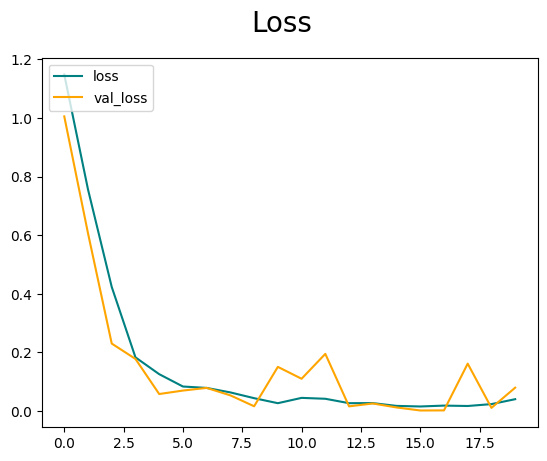

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

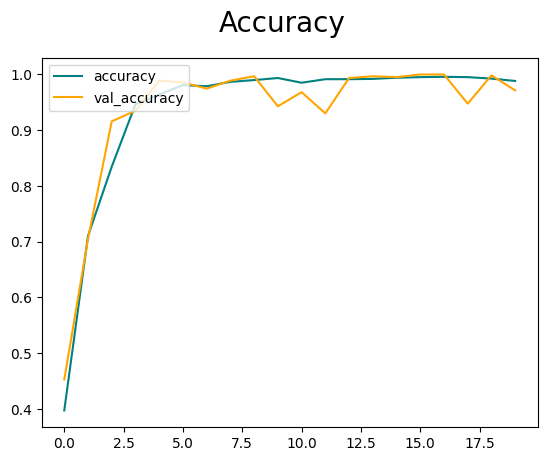

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### 3.5 Save model

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/Programowanie/Models', 'rock_paper_scissors.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4. Evaluate Performance

### 4.1 Evaluate performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
ds_test = tfds.load('rock_paper_scissors', split='test')

In [ ]:
len(ds_test)

372

In [ ]:
ds_test = ds_test.map(
    lambda batch: (batch['image'], batch['label'])
)

In [ ]:
ds_test = ds_test.map(
    lambda X, y: (X/255, y)
)

In [ ]:
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
model.evaluate(ds_test)

In [ ]:
for X, y in ds_test:
    X = np.expand_dims(X, 0)
    y = np.expand_dims(y, 0)
    yhat = model.predict(X)
    yhat = np.expand_dims(np.argmax(yhat), 0)
    pre.update_state(y, np.expand_dims(np.argmax(yhat), 0))
    re.update_state(y, np.expand_dims(np.argmax(yhat), 0))
    acc.update_state(y, np.expand_dims(np.argmax(yhat), 0))

1/1 [==============================] - 0s 23ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 18ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 19ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 24ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 27ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 20ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 26ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 18ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 21ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 23ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 18ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 20ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 19ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 21ms/step
(1, 3)
(1,)
1/1 [==============================] - 0s 23ms/step
(1, 3)
(1,)
1/1 [==============================] - 0

In [ ]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 0.9367588758468628, Recall: 0.9516128897666931, Accuracy: 0.6209677457809448


### 4.2 Save results

In [ ]:
with open("20230920_Results.txt", "w") as file:
    file.write(f'Precision: {pre.result()}')
    file.write(f'Recall: {re.result()}')
    file.write(f'Accuracy: {acc.result()}')